In [1]:
import pandas as pd
import numpy as np
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
import skimage

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap
from stardist.matching import matching_dataset
lbl_cmap = random_label_cmap()

from spatial_tools.image.manipulate import crop_img
from spatial_tools.image.tools import read_tif

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.utils import Path, download_and_extract_zip_file

%load_ext autoreload
%autoreload 2

user = "david.fischer_local"

if user == "david.fischer_local":
    dataset_folder_kidney = "/Users/david.fischer/phd/datasets/2020_10x_visium/20191205_10XVisium_MouseKidneyCoronal_giovanni.palla/"
    dataset_folder_heart = "/Users/david.fischer/phd/datasets/2020_10x_visium/20191218_10XVisium_HumanHeart_giovanni.palla/"
    dataset_folder_lymphnode = "/Users/david.fischer/phd/datasets/2020_10x_visium/20191218_10XVisium_HumanLymphNode_giovanni.palla/"
    dataset_folder_spost = "/Users/david.fischer/phd/datasets/2020_10x_visium/20191205_10XVisium_MouseBrainSerial1SP_giovanni.palla/"
else:
    dataset_folder_kidney = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla/20191205_10XVisium_MouseKidneyCoronal_giovanni.palla/"
    dataset_folder_heart = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla/20191218_10XVisium_HumanHeart_giovanni.palla/"
    dataset_folder_lymphnode = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla/20191218_10XVisium_HumanLymphNode_giovanni.palla/"
    dataset_folder_spost = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla/20191205_10XVisium_MouseBrainSerial1SP_giovanni.palla/"

# Load data

## Reference data that model was trained on

In [2]:
download_and_extract_zip_file(
    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files found, nothing to download.


In [3]:
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [4]:
X, Y = X[:10], Y[:10]

In [5]:
X = list(map(imread,X))
Y = list(map(imread,Y))

In [6]:
X[1].shape
train_res = X[1].shape[0]

## Target data to segment

In [7]:
dataset_name_kidney = "V1_Mouse_Kidney"
dataset_name_heart = "V1_Human_Heart"
dataset_name_lymphnode = "V1_Human_Lymph_Node"
dataset_name_spost = "V1_Mouse_Brain_Sagittal_Posterior"

In [8]:
adata_kidney = sc.read_visium(
    dataset_folder_kidney, count_file=f"{dataset_name_kidney}_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
adata_lymphnode = sc.read_visium(
    dataset_folder_lymphnode, count_file=f"{dataset_name_lymphnode}_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
adata_heart = sc.read_visium(
    dataset_folder_heart, count_file=f"{dataset_name_heart}_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
adata_spost = sc.read_visium(
    dataset_folder_spost, count_file=f"{dataset_name_spost}_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Segmentation

## Gaussian kernel detection

### By patch

In [12]:
def kernel_segmentation(
    X, 
    method="log", 
    channel_id=0, 
    smooth=False,
    min_sigma=10,
    max_sigma=50,
    num_sigma=20,
    threshold=10,
    sigma_smoothing=1.,
):
    fig, axes = plt.subplots(1,5, figsize=(25,5))
    axes[0].imshow(X)
    if smooth:
        X_mod = skimage.filters.gaussian(
            X, sigma=sigma_smoothing, output=None, mode='nearest', cval=0, 
            multichannel=None, preserve_range=False, truncate=3*sigma_smoothing
        )
        #X_mod = skimage.exposure.equalize_hist(X, nbins=256, mask=None)
    else:
        X_mod = X
    axes[1].imshow(X_mod)
    axes[2].imshow(X_mod[:,:,0])
    axes[3].imshow(X_mod[:,:,1])
    axes[4].imshow(X_mod[:,:,2])

    channel_id = 0
    if method == "log":
        blobs = skimage.feature.blob_log(
            image=1.-X_mod[:,:,channel_id], 
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            num_sigma=num_sigma, 
            threshold=threshold,
            overlap=0.5,
            log_scale=False, 
            exclude_border=False
        )
    elif method == "dog":
        blobs = skimage.feature.blob_dog(
            image=1.-X_mod[:,:,channel_id], 
            min_sigma=min_sigma,
            max_sigma=max_sigma, 
            threshold=threshold,
            sigma_ratio=1.6, 
            overlap=1.,
            exclude_border=False
        )
    else:
        blobs = skimage.feature.blob_doh(
            image=1.-X_mod[:,:,channel_id], 
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            num_sigma=num_sigma, 
            threshold=threshold,
            overlap=0.5, 
            log_scale=False
        )
    fig, axes = plt.subplots(1, 1, figsize=(3, 3), sharex=True, sharey=True)
    ax = [axes]
    #ax = axes.ravel()

    idx = 0
    ax[idx].imshow(X)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="red", linewidth=2, fill=True)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

    plt.tight_layout()
    plt.show()

#### Heart

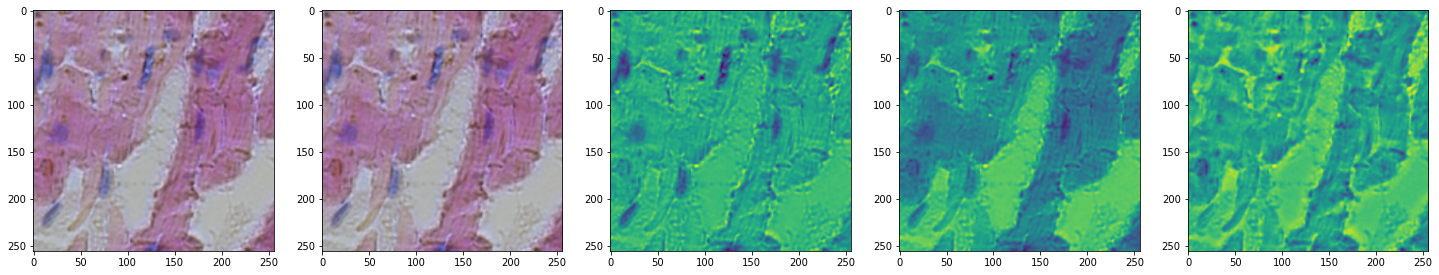

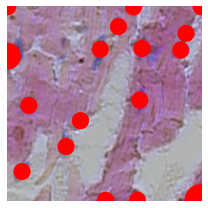

/Users/david.fischer/opt/miniconda3/lib/python3.7/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/Users/david.fischer/opt/miniconda3/lib/python3.7/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/Users/david.fischer/opt/miniconda3/lib/python3.7/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/Users/david.fischer/opt/miniconda3/lib/python3.7/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


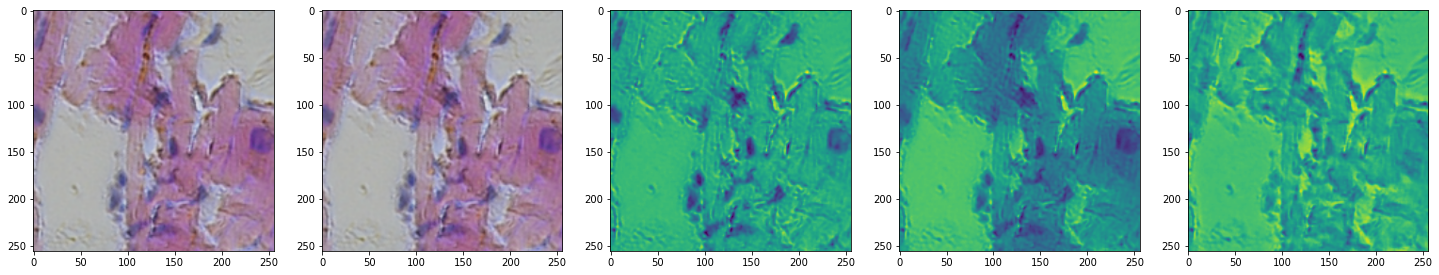

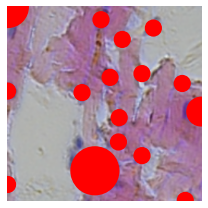

In [13]:
img = read_tif(dataset_folder_heart, dataset_name_heart)

# Spot centres
xcoord = adata_heart.obsm["spatial"][:, 0]
ycoord = adata_heart.obsm["spatial"][:, 1]
# Spot diameter
spot_diameter = adata_heart.uns['spatial'][dataset_name_heart]['scalefactors']['spot_diameter_fullres']

spot_id = 10

crop_1 = crop_img(
    img, 
    xcoord[spot_id], 
    ycoord[spot_id], 
    scalef=train_res/179, 
    sizef=2, 
    spot_diameter=spot_diameter
)

kernel_segmentation(X=crop_1, method="log", channel_id=0, smooth=False)

spot_id = 20

crop_1 = crop_img(
    img, 
    xcoord[spot_id], 
    ycoord[spot_id], 
    scalef=train_res/179, 
    sizef=2, 
    spot_diameter=spot_diameter
)

kernel_segmentation(X=crop_1, method="log", channel_id=0, smooth=False)

#### Saggital posterior

/Users/david.fischer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.


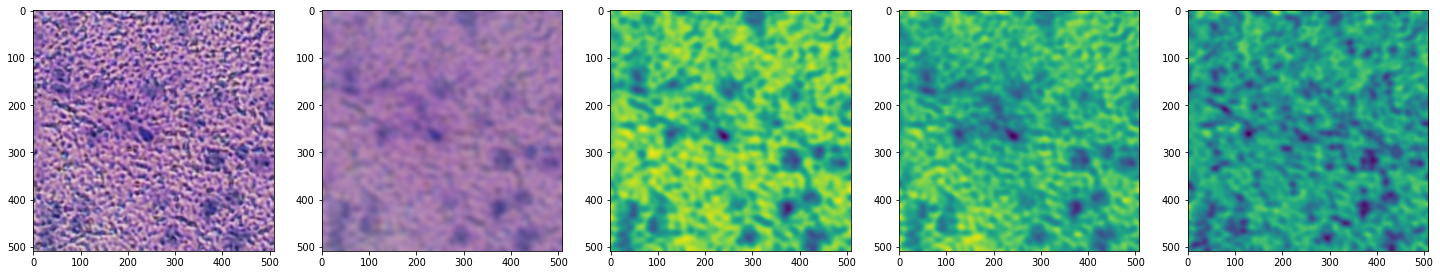

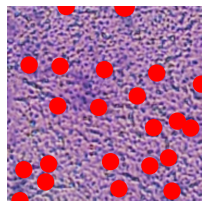

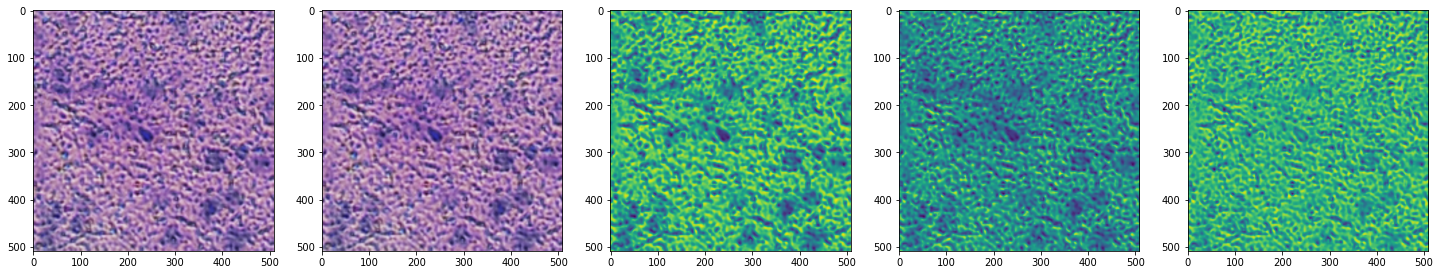

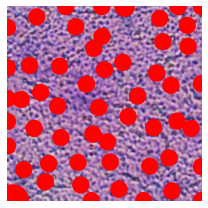

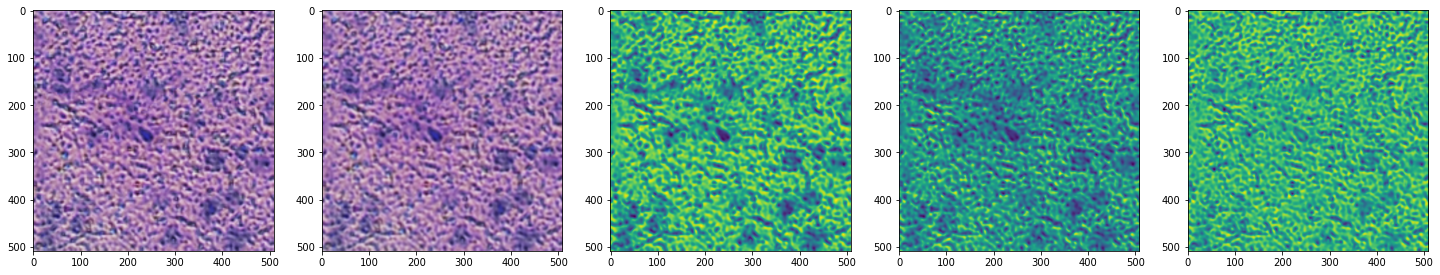

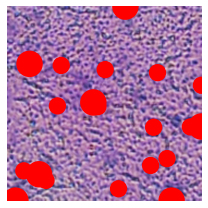

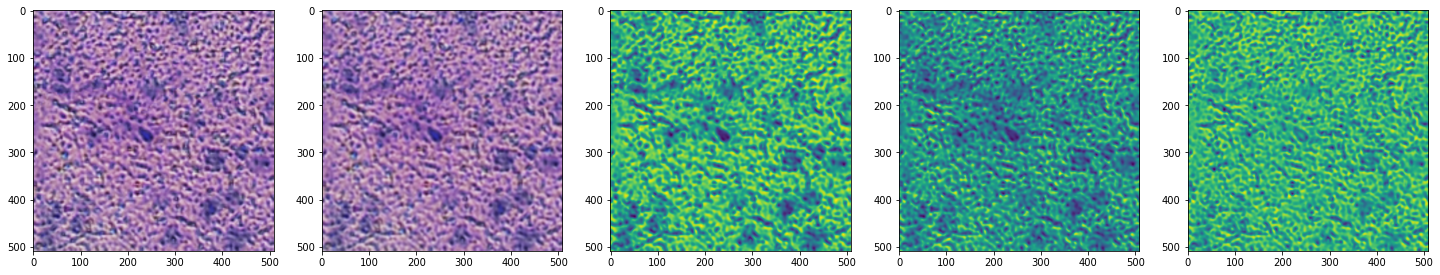

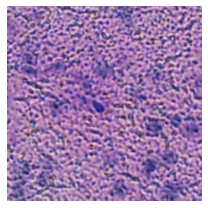

In [14]:
img = read_tif(dataset_folder_spost, dataset_name_spost)

# Spot centres
xcoord = adata_spost.obsm["spatial"][:, 0]
ycoord = adata_spost.obsm["spatial"][:, 1]
# Spot diameter
spot_diameter = adata_spost.uns['spatial'][dataset_name_spost]['scalefactors']['spot_diameter_fullres']

spot_id = 100

crop_1 = crop_img(
    img, 
    xcoord[spot_id], 
    ycoord[spot_id], 
    scalef=train_res/90, 
    sizef=2, 
    spot_diameter=spot_diameter,
)

kernel_segmentation(
    X=crop_1, 
    method="log", 
    channel_id=0, 
    smooth=True,
    sigma_smoothing=6.,
    min_sigma=20,
    max_sigma=40,
    num_sigma=20,
    threshold=0.05,
)
kernel_segmentation(
    X=crop_1, 
    method="log", 
    channel_id=0, 
    smooth=False,
    min_sigma=20,
    max_sigma=40,
    num_sigma=20,
    threshold=0.1,
)
kernel_segmentation(
    X=crop_1, 
    method="dog", 
    channel_id=0, 
    smooth=True,
    min_sigma=20,
    max_sigma=40,
    num_sigma=20,
    threshold=0.5,
)
kernel_segmentation(
    X=crop_1, 
    method="doh", 
    channel_id=0, 
    smooth=True,
    min_sigma=10,
    max_sigma=100,
    num_sigma=20,
    threshold=0.02,
)

/Users/david.fischer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.


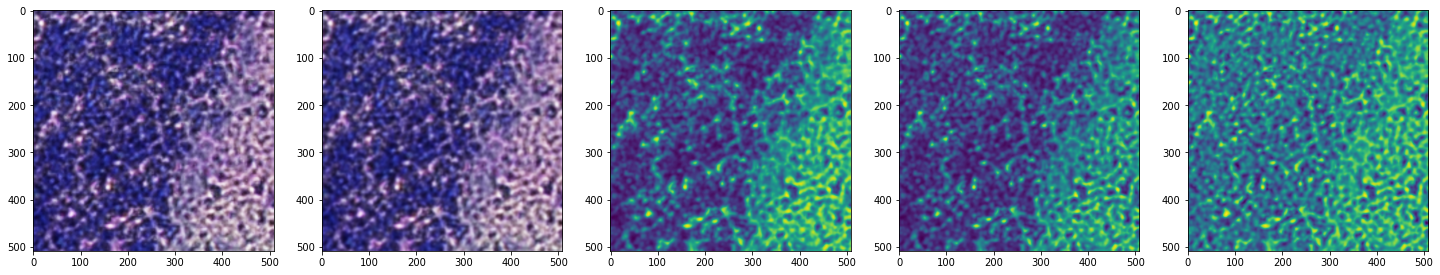

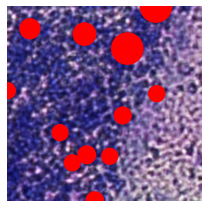

In [15]:
spot_id = 1200

crop_1 = crop_img(
    img, 
    xcoord[spot_id], 
    ycoord[spot_id], 
    scalef=train_res/90, 
    sizef=2, 
    spot_diameter=spot_diameter
)

kernel_segmentation(
    X=crop_1, 
    method="log", 
    channel_id=0, 
    smooth=True,
    min_sigma=20,
    max_sigma=40,
    num_sigma=20,
    threshold=0.1,
)

/Users/david.fischer/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.


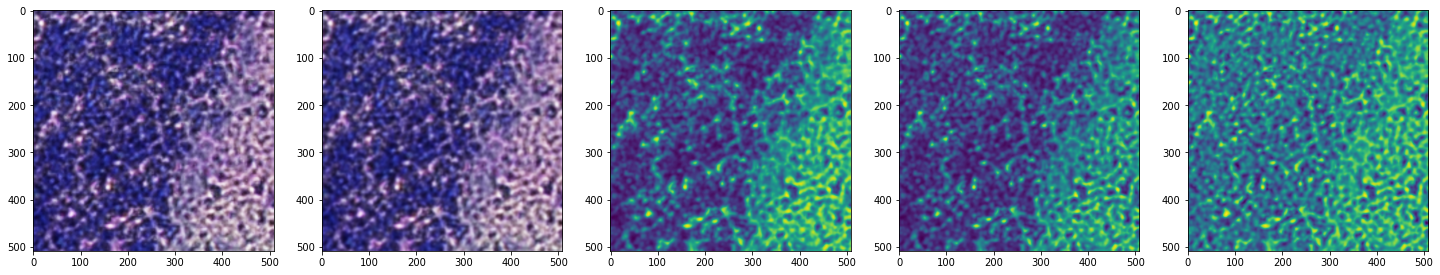

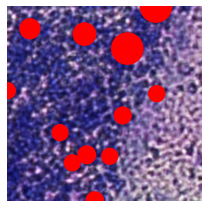

In [16]:
spot_id = 1200

crop_1 = crop_img(
    img, 
    xcoord[spot_id], 
    ycoord[spot_id], 
    scalef=train_res/90, 
    sizef=2, 
    spot_diameter=spot_diameter
)

kernel_segmentation(
    X=crop_1, 
    method="log", 
    channel_id=0, 
    smooth=True,
    min_sigma=20,
    max_sigma=40,
    num_sigma=20,
    threshold=0.1,
)

## Stardist

In [ ]:
model = StarDist2D.from_pretrained('2D_versatile_he')
#model = StarDist2D(None, name='stardist', basedir='models')

In [ ]:
model

In [ ]:
def example(model, i, X, show_dist=True, axis_norm=(0,1)):
    img = normalize(X, 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

### Stardist - globally

#### Heart

In [ ]:
img = normalize(adata_heart.uns["spatial"][dataset_name_heart]['images']["hires"], 1,99.8, axis=(0,1))
labels, details = model.predict_instances(img)
example(model, 15, adata_heart.uns["spatial"][dataset_name_heart]["images"]["hires"], False)

#### Lymph node

In [ ]:
img = normalize(adata_lymphnode.uns["spatial"][dataset_name_lymphnode]['images']["hires"], 1,99.8, axis=(0,1))
labels, details = model.predict_instances(img)
example(model, 15, adata_lymphnode.uns["spatial"][dataset_name_lymphnode]["images"]["hires"], False)

#### Kidney

In [ ]:
img = normalize(adata_kidney.uns["spatial"][dataset_name_kidney]['images']["hires"], 1,99.8, axis=(0,1))
labels, details = model.predict_instances(img)
example(model, 15, adata_kidney.uns["spatial"][dataset_name_kidney]["images"]["hires"], False)

#### Saggital Posterior

In [ ]:
img = normalize(adata_spost.uns["spatial"][dataset_name_spost]['images']["hires"], 1,99.8, axis=(0,1))
labels, details = model.predict_instances(img)
example(model, 15, adata_spost.uns["spatial"][dataset_name_spost]["images"]["hires"], False)

### Stardist by patch

#### Heart

In [ ]:
img = read_tif(dataset_folder_heart, dataset_name_heart)

# Spot centres
xcoord = adata_heart.obsm["spatial"][:, 0]
ycoord = adata_heart.obsm["spatial"][:, 1]
# Spot diameter
spot_diameter = adata_heart.uns['spatial'][dataset_name_heart]['scalefactors']['spot_diameter_fullres']

spot_id = 10

crop_1 = crop_img(
    img, 
    xcoord[spot_id], 
    ycoord[spot_id], 
    scalef=train_res/179, 
    sizef=1, 
    spot_diameter=spot_diameter
)

fig, axes = plt.subplots(1,1)
axes.imshow(crop_1)

print(crop_1.shape)

labels, details = model.predict_instances(crop_1)
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');
#example(model, 15, img, False)  # too much memory

#### Lymph node

In [ ]:
img = read_tif(dataset_folder_lymphnode, dataset_name_lymphnode)

# Spot centres
xcoord = adata_lymphnode.obsm["spatial"][:, 0]
ycoord = adata_lymphnode.obsm["spatial"][:, 1]
# Spot diameter
spot_diameter = adata_lymphnode.uns['spatial'][dataset_name_lymphnode]['scalefactors']['spot_diameter_fullres']

spot_id = 10

crop_1 = crop_img(
    img, 
    xcoord[spot_id], 
    ycoord[spot_id], 
    scalef=train_res/179, 
    sizef=1, 
    spot_diameter=spot_diameter
)

fig, axes = plt.subplots(1,1)
axes.imshow(crop_1)

print(crop_1.shape)

labels, details = model.predict_instances(crop_1)
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');
#example(model, 15, img, False)  # too much memory

#### Kidney

In [ ]:
img = read_tif(dataset_folder_kidney, dataset_name_kidney)

# Spot centres
xcoord = adata_kidney.obsm["spatial"][:, 0]
ycoord = adata_kidney.obsm["spatial"][:, 1]
# Spot diameter
spot_diameter = adata_kidney.uns['spatial'][dataset_name_kidney]['scalefactors']['spot_diameter_fullres']

spot_id = 10

crop_1 = crop_img(
    img,
    xcoord[spot_id],
    ycoord[spot_id],
    scalef=train_res/89, 
    sizef=1,
    spot_diameter=spot_diameter
)

fig, axes = plt.subplots(1,1)
axes.imshow(crop_1)

print(crop_1.shape)

labels, details = model.predict_instances(crop_1)
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');
#example(model, 15, img, False)  # too much memory

#### Saggistal Posterior

In [ ]:
img = read_tif(dataset_folder_spost, dataset_name_spost)

# Spot centres
xcoord = adata_spost.obsm["spatial"][:, 0]
ycoord = adata_spost.obsm["spatial"][:, 1]
# Spot diameter
spot_diameter = adata_spost.uns['spatial'][dataset_name_spost]['scalefactors']['spot_diameter_fullres']

spot_id = 100

crop_1 = crop_img(
    img,
    xcoord[spot_id],
    ycoord[spot_id],
    scalef=train_res/90, 
    sizef=2,
    spot_diameter=spot_diameter
)
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(crop_1)

crop_1 = skimage.filters.gaussian(
    crop_1, sigma=4, output=None, mode='nearest', cval=0, 
    multichannel=True, preserve_range=False, truncate=20.0
)
#crop_1 = np.concatenate([
#    np.expand_dims(scipy.ndimage.uniform_filter(crop_1[:,:,i], size=5), axis=-1)
#    for i in range(crop_1.shape[2])
#], axis=-1)
#crop_1 = skimage.exposure.equalize_hist(crop_1, nbins=256, mask=None)

axes[1].imshow(crop_1)

print(crop_1.shape)

labels, details = model.predict_instances(crop_1)
axes[2].imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
axes[2].imshow(labels, cmap=lbl_cmap, alpha=0.5)
#example(model, 15, img, False)  # too much memory